# Tox21 compounds

Tox21 compounds obtained _via_ PubChem PUG API.

https://pubchem.ncbi.nlm.nih.gov/pug_rest/PUG_REST.html

### Configuration and Setup

In [2]:
%run setup.py

In [2]:
import time

### Config

In [3]:
# PUG API URL to retrieve all SIDs for Tox21 assays...

sids_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceall/{source}/sids/JSON'

source = 'Tox21' # Source name for Tox21 data

# PUG API URL to retrieve CID for each of a list of SIDs...

cids_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sid/{sids}/cids/JSON"

# PUG API URL to retrieve properties for each of a list of CIDs...

props_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cids}/property/{props}/JSON"

# PUG API URL to retrieve parent CID for each of a list of CIDs...

parent_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/cids/JSON?cids_type=parent"

In [4]:
# Number of entities to request data for in each call to PUG API...

chunk_size = 100

In [4]:
# Directory for reading and writing data files...

data_dir = 'data'

### Initialisation

In [5]:
if not 'logger' in locals(): logger = make_logger.run(__name__)

## Get Tox21  compounds

Query PubChem PUG API for substances tested in Tox21 assays (_i.e._ SIDs) and get the corresponding (version) compounds (_i.e._ CIDs)

In [6]:
# Get list of all SIDs associated with Tox21...

sids = requests.get(sids_url.format(source=source)).json()['IdentifierList']['SID']

n_sids = len(sids)

n_sids

14406

In [7]:
# Get the CID for each SID...

logger.info("Getting CID for SIDs: {} to do ({} chunks)".format(n_sids, ceil(n_sids/chunk_size)))

found, failed = [], []

for n, chunk in enumerate((sids[i:i+chunk_size] for i in range(0, n_sids, chunk_size)), 1):
    
    logger.info("Starting chunk {}...".format(n))
    
    response = requests.get(cids_url.format(sids=','.join(str(x) for x in chunk)))

    assert response.status_code == 200

    for record in response.json()['InformationList']['Information']:
        
        sid = record['SID']

        if not 'CID' in record:

            logger.warning("No CIDs for SID {}".format(sid))
            
            failed.append(sid)

            continue

        found.append((sid, record['CID'][0]))

logger.info("Finished.")

sids_cids_df = pd.DataFrame(found, columns=['SID', 'CID'])

[25/01/17 13:55:24 __main__ INFO] Getting CID for SIDs: 14406 to do (145 chunks)
[25/01/17 13:55:24 __main__ INFO] Starting chunk 1...
[25/01/17 13:55:25 __main__ INFO] Starting chunk 2...
[25/01/17 13:55:26 __main__ INFO] Starting chunk 3...
[25/01/17 13:55:27 __main__ WARNING] No CIDs for SID 312345169
[25/01/17 13:55:27 __main__ INFO] Starting chunk 4...
[25/01/17 13:55:28 __main__ INFO] Starting chunk 5...
[25/01/17 13:55:28 __main__ INFO] Starting chunk 6...
[25/01/17 13:55:29 __main__ INFO] Starting chunk 7...
[25/01/17 13:55:29 __main__ INFO] Starting chunk 8...
[25/01/17 13:55:30 __main__ WARNING] No CIDs for SID 312344671
[25/01/17 13:55:30 __main__ INFO] Starting chunk 9...
[25/01/17 13:55:30 __main__ INFO] Starting chunk 10...
[25/01/17 13:55:31 __main__ INFO] Starting chunk 11...
[25/01/17 13:55:31 __main__ INFO] Starting chunk 12...
[25/01/17 13:55:32 __main__ INFO] Starting chunk 13...
[25/01/17 13:55:32 __main__ WARNING] No CIDs for SID 251919991
[25/01/17 13:55:32 __mai

In [8]:
sids_cids_df.shape

(14252, 2)

In [9]:
assert sids_cids_df.shape[0] + len(failed) == n_sids

In [10]:
sids_cids_df.head()

,SID,CID
0,312345403,6436006
1,312345402,51371303
2,312345401,5487088
3,312345400,5665
4,312345399,11957730


In [11]:
# sids_cids_df.to_pickle(os.path.join(data_dir, 'sids_cids.pkl'))

In [12]:
# sids_cids_df = pd.read_pickle(os.path.join(data_dir, 'sids_cids.df'))

# sids_cids_df.shape

<a name="version_structures"></a>

## Get structures for compounds

Get structures (as PubChem 'IsomericSMILES') for the compounds (_i.e._ CIDs) corresponding to the substances (_i.e._ SIDs) tested in the Tox21 assays.

Note that these compounds/CIDs are 'versions', _i.e._ they contain salt/solvate components.

In [13]:
# Get set of unique CIDs...

cids = sids_cids_df['CID'].unique()

n_cids = len(cids)

n_cids

9594

In [14]:
# Get structures for unique CIDs...

logger.info("Getting structures for CIDs: {} to do ({} chunks)".format(n_cids, ceil(n_cids/chunk_size)))

props = ['IsomericSMILES']

dfs = []

for n, chunk in enumerate((cids[i:i+chunk_size] for i in range(0, n_cids, chunk_size)), 1):
    
    logger.info("Starting chunk {}...".format(n))
    
    response = requests.get(props_url.format(cids=','.join(str(x) for x in chunk), props=','.join(props)))

    assert response.status_code == 200
    
    df = pd.DataFrame(response.json()['PropertyTable']['Properties'], columns=['CID'] + props)

    dfs.append(df)

logger.info("Finished.")

version_mols_df = pd.concat(dfs).sort_values('CID').reset_index(drop=True)

[25/01/17 13:56:31 __main__ INFO] Getting structures for CIDs: 9594 to do (96 chunks)
[25/01/17 13:56:31 __main__ INFO] Starting chunk 1...
[25/01/17 13:56:31 __main__ INFO] Starting chunk 2...
[25/01/17 13:56:32 __main__ INFO] Starting chunk 3...
[25/01/17 13:56:32 __main__ INFO] Starting chunk 4...
[25/01/17 13:56:33 __main__ INFO] Starting chunk 5...
[25/01/17 13:56:33 __main__ INFO] Starting chunk 6...
[25/01/17 13:56:34 __main__ INFO] Starting chunk 7...
[25/01/17 13:56:34 __main__ INFO] Starting chunk 8...
[25/01/17 13:56:35 __main__ INFO] Starting chunk 9...
[25/01/17 13:56:35 __main__ INFO] Starting chunk 10...
[25/01/17 13:56:36 __main__ INFO] Starting chunk 11...
[25/01/17 13:56:36 __main__ INFO] Starting chunk 12...
[25/01/17 13:56:37 __main__ INFO] Starting chunk 13...
[25/01/17 13:56:37 __main__ INFO] Starting chunk 14...
[25/01/17 13:56:38 __main__ INFO] Starting chunk 15...
[25/01/17 13:56:38 __main__ INFO] Starting chunk 16...
[25/01/17 13:56:39 __main__ INFO] Starting 

In [15]:
version_mols_df.shape

(9594, 2)

In [16]:
# Check all CIDs have SMILES...

assert (version_mols_df['IsomericSMILES'] == '').sum() == 0

In [17]:
# Add RDKit molecules...

PandasTools.AddMoleculeColumnToFrame(version_mols_df, smilesCol='IsomericSMILES', molCol='mol')

RDKit ERROR: [13:57:18] Explicit valence for atom # 1 Si, 8, is greater than permitted
RDKit ERROR: [13:57:18] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [13:57:19] Explicit valence for atom # 6 Bi, 5, is greater than permitted


In [18]:
# Three failures to build mol...

version_mols_df[version_mols_df['mol'].isnull()]

,CID,IsomericSMILES,mol
4203,28127,F[Si-2](F)(F)(F)(F)F.[Na+].[Na+],None
4204,28145,[NH4+].[NH4+].F[Si-2](F)(F)(F)(F)F,None
6749,299728,C1=CC=C(C=C1)[Bi](C2=CC=CC=C2)(C3=CC=CC=C3)(Cl)Cl,None


In [19]:
# Remove cases where no mol was built...

version_mols_df = version_mols_df[~version_mols_df['mol'].isnull()].copy()

version_mols_df.shape

(9591, 3)

In [20]:
# Simplify column names...

version_mols_df.rename(inplace=True, columns={
                 'IsomericSMILES': 'version_smiles'
               , 'mol':            'version_mol'
            })

,CID,version_smiles,version_mol
0,4,CC(CN)O,

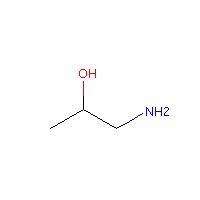

In [21]:
version_mols_df.head(1)

In [22]:
# version_mols_df.to_pickle(os.path.join(data_dir, 'version_mols.pkl'))

In [23]:
# version_mols_df = pd.read_pickle(os.path.join(data_dir, 'version_mols.df'))

# version_mols_df.shape

See notebook [Tox21_PubChem_compounds_02](Tox21_PubChem_compounds_02.ipynb) for a use of this file.

## Parent CIDs

Use the PubChem PUG API to get the parent CIDs corresponding to the version CIDs tested in the Tox21 assays.

Note taht the sleep/retry mechanism was added after an occasion where requests would occasionally fail with HTTP status codes of 400 or 500, and retrying would sometimes result in a successful request. However, the problem seems to have gone away, so this code is probably redundant now.

In [24]:
# Get the parent CID for each CID...

max_tries = 10

chunk_size = 10

logger.info("Getting parent CID for CIDs: {} to do".format(n_cids))

rows = []

for n, cid in enumerate(cids, 1):
    
    parent_cid = 0 # NB On failure, use integer flag instead of None so column is not coerced to float so to accomodate None/NaN
    
    for n_try in range(1, max_tries+1):
        
        response = requests.get(parent_url.format(cid=cid))

        if response.status_code == 200:

            parent_cid = response.json()['IdentifierList']['CID'][0]
            
            break
            
        elif response.status_code == 404: # No parent compound is available
            
            break

        else:
                        
            time.sleep(n_try)
                            
    rows.append((cid, parent_cid, response.status_code))
    
    if n % chunk_size == 0: logger.info("...done {}...".format(n))
    
logger.info("Finished: did {} in total.".format(n))
    
parent_cids_df = pd.DataFrame(rows, columns=['CID', 'parent_CID', 'status_code'])

[25/01/17 13:57:20 __main__ INFO] Getting parent CID for CIDs: 9594 to do
[25/01/17 13:57:33 __main__ INFO] ...done 10...
[25/01/17 13:57:46 __main__ INFO] ...done 20...
[25/01/17 13:57:59 __main__ INFO] ...done 30...
[25/01/17 13:58:12 __main__ INFO] ...done 40...
[25/01/17 13:58:25 __main__ INFO] ...done 50...
[25/01/17 13:58:38 __main__ INFO] ...done 60...
[25/01/17 13:58:53 __main__ INFO] ...done 70...
[25/01/17 13:59:06 __main__ INFO] ...done 80...
[25/01/17 13:59:18 __main__ INFO] ...done 90...
[25/01/17 13:59:31 __main__ INFO] ...done 100...
[25/01/17 13:59:43 __main__ INFO] ...done 110...
[25/01/17 13:59:56 __main__ INFO] ...done 120...
[25/01/17 14:00:09 __main__ INFO] ...done 130...
[25/01/17 14:00:23 __main__ INFO] ...done 140...
[25/01/17 14:00:36 __main__ INFO] ...done 150...
[25/01/17 14:00:50 __main__ INFO] ...done 160...
[25/01/17 14:01:03 __main__ INFO] ...done 170...
[25/01/17 14:01:17 __main__ INFO] ...done 180...
[25/01/17 14:01:31 __main__ INFO] ...done 190...
[25/

In [25]:
parent_cids_df.shape

(9594, 3)

In [26]:
parent_cids_df.head()

,CID,parent_CID,status_code
0,6436006,5365247,200
1,51371303,51371303,200
2,5487088,5487088,200
3,5665,5665,200
4,11957730,5615,200


In [27]:
parent_cids_df.query("parent_CID == 0").shape

(179, 3)

In [28]:
parent_cids_df.query("parent_CID == 0")['status_code'].value_counts().to_frame('count').reset_index().rename(columns={'index': 'status_code'})

,status_code,count
0,404,179


In [29]:
# parent_cids_df.to_pickle(os.path.join(data_dir, 'parent_cids.pkl'))

In [30]:
# parent_cids_df = pd.read_pickle(os.path.join(data_dir, 'parent_cids.df'))

# parent_cids_df.shape

<a name="multi_cid_parents"></a>

## Multi-CID parents

Inspect the parent CIDs with multiple corresponding version CIDs.

In [31]:
def f(df):
    
    cids = df['CID'].tolist()
    
    N = len(cids)
    
    return pd.Series([cids if N > 1 else cids[0], N], index=['CID', 'N'])

count_cids_df = (
    parent_cids_df
        .query("parent_CID != 0")
        .groupby('parent_CID')
        .apply(f)
        .sort_values('N', ascending=False)
        .reset_index(drop=False)
    )

count_cids_df.shape

(8897, 3)

In [32]:
count_cids_df.query("N > 1").shape

(393, 3)

In [33]:
count_cids_df.query("N > 1").head(10)

,parent_CID,CID,N
0,157857,"[16726630, 12184311, 60196379, 10411334, 60196375, 21932259, 11750474, 11258643, 11181836, 11048104, 11731903, 12184591, 53316418, 12040508, 25171607, 53316417, 11212667, 16211009, 53260965, 12991988, 53316407, 12040509, 44630019]",23
1,62406,"[62406, 60196396, 60196393, 2734249, 13638937, 2734248, 60196392, 23079882, 60196390, 60196383, 16210995, 23160059, 2734246, 2734250, 12195864, 2758874, 16212746, 22239085]",18
2,176,"[12525, 11192, 15337, 176, 23354, 517045, 517044, 8896, 14012, 11247, 6277]",11
3,7612,"[7612, 79154, 5284468, 62390, 7611, 92884]",6
4,6101,"[3720192, 521998, 10636633, 6101, 16218739, 21517]",6
5,2734228,"[16211417, 46226173, 16749605, 10250129, 2734227]",5
6,174076,"[11075478, 2734235, 11159638, 2734160, 16211115]",5
7,5143,"[5143, 22879, 64772, 443755, 656582]",5
8,305,"[74724, 31255, 6209, 11643980]",4
9,338,"[338, 16760658, 54693468, 3045402]",4


## Parent structures

Use PubChem PUG API to get structures (as PubChem 'IsomericSMILES' and InChIs/InChI Keys) for the parent compounds (_i.e._ CIDs) tested in the Tox21 assays.

In [34]:
# Get list of unique parent CIDs...

cids = parent_cids_df.query("parent_CID != 0")['parent_CID'].unique()

n_cids = len(cids)

n_cids

8897

_N.B._ See also the [multi-CID parents](#multi_cid_parents) section above.

In [35]:
# Get structures for unique parent CIDs...

logger.info("Getting structures for parent CIDs: {} to do ({} chunks)".format(n_cids, ceil(n_cids/chunk_size)))

props = ['IsomericSMILES', 'InChI', 'InChIKey']

dfs = []

for n, chunk in enumerate((cids[i:i+chunk_size] for i in range(0, n_cids, chunk_size)), 1):
    
    logger.info("Starting chunk {}...".format(n))
    
    response = requests.get(props_url.format(cids=','.join(str(x) for x in chunk), props=','.join(props)))
    
    df = pd.DataFrame(response.json()['PropertyTable']['Properties'], columns=['CID'] + props)

    dfs.append(df)
    
logger.info("Finished.")
    
parent_mols_df = pd.concat(dfs)

[25/01/17 17:39:29 __main__ INFO] Getting structures for parent CIDs: 8897 to do (890 chunks)
[25/01/17 17:39:29 __main__ INFO] Starting chunk 1...
[25/01/17 17:39:30 __main__ INFO] Starting chunk 2...
[25/01/17 17:39:30 __main__ INFO] Starting chunk 3...
[25/01/17 17:39:31 __main__ INFO] Starting chunk 4...
[25/01/17 17:39:32 __main__ INFO] Starting chunk 5...
[25/01/17 17:39:33 __main__ INFO] Starting chunk 6...
[25/01/17 17:39:33 __main__ INFO] Starting chunk 7...
[25/01/17 17:39:34 __main__ INFO] Starting chunk 8...
[25/01/17 17:39:35 __main__ INFO] Starting chunk 9...
[25/01/17 17:39:35 __main__ INFO] Starting chunk 10...
[25/01/17 17:39:36 __main__ INFO] Starting chunk 11...
[25/01/17 17:39:36 __main__ INFO] Starting chunk 12...
[25/01/17 17:39:37 __main__ INFO] Starting chunk 13...
[25/01/17 17:39:38 __main__ INFO] Starting chunk 14...
[25/01/17 17:39:38 __main__ INFO] Starting chunk 15...
[25/01/17 17:39:39 __main__ INFO] Starting chunk 16...
[25/01/17 17:39:39 __main__ INFO] S

In [36]:
parent_mols_df.shape

(8897, 4)

In [37]:
# Add RDKit molecules for parent structures...

PandasTools.AddMoleculeColumnToFrame(parent_mols_df, smilesCol='IsomericSMILES', molCol='mol')

RDKit ERROR: [17:48:24] Explicit valence for atom # 6 Bi, 5, is greater than permitted


In [38]:
# Remove cases where no mol was built...

parent_mols_df = parent_mols_df[~parent_mols_df['mol'].isnull()]

parent_mols_df.shape

(8896, 5)

In [39]:
# Simplify column names...

parent_mols_df.rename(inplace=True, columns={
                  'CID':            'parent_CID'
                , 'IsomericSMILES': 'parent_smiles'
                , 'mol':            'parent_mol'
                , 'InChI':          'inchi'
                , 'InChIKey':       'inchikey'
            })

### parent_mols_df = parent_mols_df[['parent_CID', 'parent_smiles', 'parent_mol', 'inchi', 'inchikey']]

,parent_CID,parent_smiles,inchi,inchikey,parent_mol
0,5365247,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2,"InChI=1S/C16H17BrN2/c1-19(2)11-9-16(14-4-3-10-18-12-14)13-5-7-15(17)8-6-13/h3-10,12H,11H2,1-2H3/b16-9-",OYPPVKRFBIWMSX-SXGWCWSVSA-N,

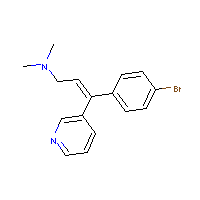

In [40]:
parent_mols_df.head(1)

## Combine tables

Join tables to create master table of compound structures.

In [41]:
parent_cids_df.shape, version_mols_df.shape, parent_mols_df.shape

((9594, 3), (9591, 3), (8896, 5))

In [42]:
parent_cids_df.head(1)

,CID,parent_CID,status_code
0,6436006,5365247,200


,CID,version_smiles,version_mol
0,4,CC(CN)O,

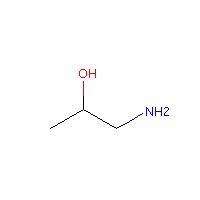

In [43]:
version_mols_df.head(1)

,parent_CID,parent_smiles,inchi,inchikey,parent_mol
0,5365247,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2,"InChI=1S/C16H17BrN2/c1-19(2)11-9-16(14-4-3-10-18-12-14)13-5-7-15(17)8-6-13/h3-10,12H,11H2,1-2H3/b16-9-",OYPPVKRFBIWMSX-SXGWCWSVSA-N,

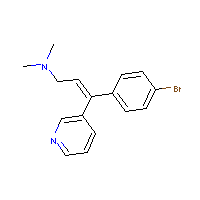

In [44]:
parent_mols_df.head(1)

In [45]:
tox21_compounds_df = (
    parent_cids_df
        .merge(version_mols_df, on='CID', how='left')
        .merge(parent_mols_df, on='parent_CID', how='left')
        .drop(['status_code'], axis=1)
    )

tox21_compounds_df.shape

(9594, 8)

In [46]:
# Simplify column names...

tox21_compounds_df.rename(inplace=True, columns={
          'parent_smiles':         'smiles'
        , 'parent_mol':            'mol'
    })

,CID,parent_CID,version_smiles,version_mol,smiles,inchi,inchikey,mol
0,6436006,5365247,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2.Cl.Cl,,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2,"InChI=1S/C16H17BrN2/c1-19(2)11-9-16(14-4-3-10-18-12-14)13-5-7-15(17)8-6-13/h3-10,12H,11H2,1-2H3/b16-9-",OYPPVKRFBIWMSX-SXGWCWSVSA-N,

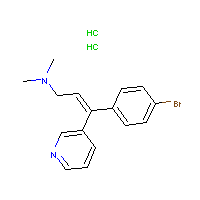
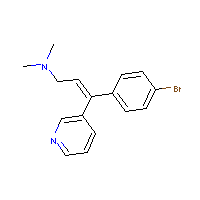

In [47]:
tox21_compounds_df.head(1)

In [48]:
# Check some counts...

((tox21_compounds_df['parent_CID'] == 0).sum(), tox21_compounds_df['mol'].isnull().sum())

(179, 180)

In [49]:
# tox21_compounds_df.to_pickle(os.path.join(data_dir, 'tox21_compounds.pkl'))

In [6]:
# tox21_compounds_df = pd.read_pickle(os.path.join(data_dir, 'tox21_compounds.pkl'))

# tox21_compounds_df.shape

### Convenience table mapping SIDs directly to structures

In [51]:
sid_mols_df = sids_cids_df.merge(tox21_compounds_df, on='CID')[['SID', 'CID', 'parent_CID', 'smiles', 'inchi', 'inchikey', 'mol']]

sid_mols_df.shape

(14252, 7)

,SID,CID,parent_CID,smiles,inchi,inchikey,mol
0,312345403,6436006,5365247,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2,"InChI=1S/C16H17BrN2/c1-19(2)11-9-16(14-4-3-10-18-12-14)13-5-7-15(17)8-6-13/h3-10,12H,11H2,1-2H3/b16-9-",OYPPVKRFBIWMSX-SXGWCWSVSA-N,

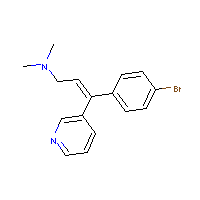

In [52]:
sid_mols_df.head(1)

In [53]:
sid_mols_df.to_pickle(os.path.join(data_dir, 'sid_mols.pkl'))

In [7]:
sid_mols_df = pd.read_pickle(os.path.join(data_dir, 'sid_mols.pkl'))

sid_mols_df.shape

(14252, 7)

### Inspect version / parent differences

In [55]:
diff_df = tox21_compounds_df.query("CID != parent_CID and parent_CID != 0")

diff_df.shape

(2004, 8)

,CID,parent_CID,version_smiles,version_mol,smiles,inchi,inchikey,mol
0,6436006,5365247,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2.Cl.Cl,,CN(C)C/C=C(/C1=CC=C(C=C1)Br)\C2=CN=CC=C2,"InChI=1S/C16H17BrN2/c1-19(2)11-9-16(14-4-3-10-18-12-14)13-5-7-15(17)8-6-13/h3-10,12H,11H2,1-2H3/b16-9-",OYPPVKRFBIWMSX-SXGWCWSVSA-N,

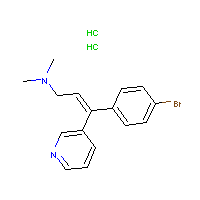
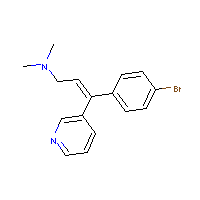

In [56]:
diff_df.head(1)

,CID,parent_CID,version_mol,mol
0,6436006,5365247,,
4,11957730,5615,,
6,56972205,9950868,,
7,11957728,11957729,,
10,115227,4593,,

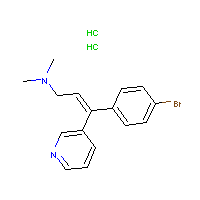
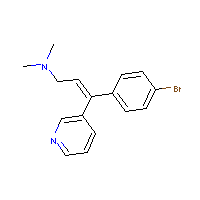
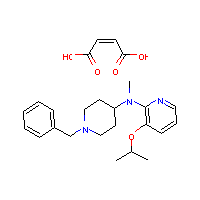
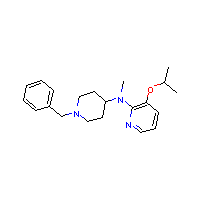
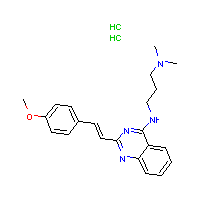
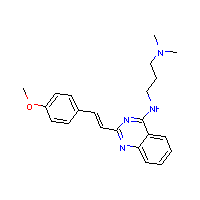
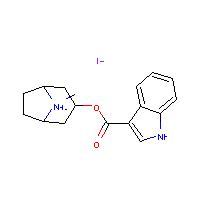
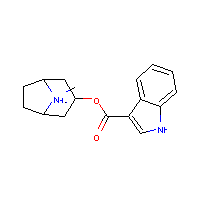
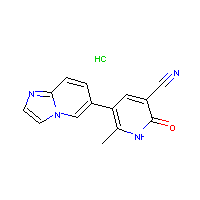
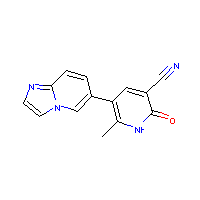

In [57]:
diff_df[['CID', 'parent_CID', 'version_mol', 'mol']].head()

### Overlap with EU-ToxRisk case-study compounds

See [here](Tox21_compounds_vs_case_study_compounds.ipynb) for further details.